
# Predict Show-up or No-show

### Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Wrangling</a></li>
<li><a href="#eda">EDA</a></li>
<li><a href="#conclusions">Conclusion</a></li>
</ul>

<a id='intro'></a>
## 1.Introduction

> 
This dataset includes around 110,000 registration records of Brazilian patients,such as ScheuduledDay means on which day the patient made the appointment;Neighborhood indicates the location of hospital;Scholarship means if the patient is involved in welfare program 'Bolsa Familia';and variable in last column shows if the patient showed up or not,'No' indicates show-up,'Yes' indicates no-show.
>
Questions:
1.How many patiens had No-show? 
2.Which variables have high correlation to No-show?

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
% matplotlib inline

# import data 

df=pd.read_csv('noshowappointments.csv')

<a id='wrangling'></a>
## 2.Wrangling


##### check the data,missing value, incorrect data type, duplicates


In [2]:
df.shape

(110527, 14)

In [3]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
sum(df.duplicated())

0

In [6]:
type(df['ScheduledDay'][0])

str

In [7]:
# Drop unnecessory column 'AppointmentID'
df.drop(['AppointmentID'], axis =1, inplace=True)

In [8]:
# Correct typos 'hipertension', 'handcap'
df.rename(columns=lambda x: x.lower(), inplace=True)
df.rename(columns={'hipertension':'hypertension','handcap':'handicap'},inplace=True)

In [9]:
# Correct incorrect data type 'scheduledday', 'appointmentday'
df['scheduledday']=pd.to_datetime(df['scheduledday']).dt.date.astype('datetime64[ns]')
df['appointmentday']=pd.to_datetime(df['appointmentday']).dt.date.astype('datetime64[ns]')

In [10]:
# check corrected data
df.tail(2)

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
110525,9.213493e+13,F,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,F,2016-04-27,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,No


<a id='eda'></a>
## 3.EDA

#### Create new features & Remove outliers

In [11]:
df.describe()

,patientid,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [12]:
# create new feature 'awaiting days'
df['awaiting_days']=df['appointmentday']-df['scheduledday']
df['awaiting_days'] = df['awaiting_days'].dt.days

In [13]:
# create new features 'appointment_weekday' and 'scheduled_weekday'
df['appointment_weekday']=df.appointmentday.dt.weekday_name
df['scheduled_weekday']=df.scheduledday.dt.weekday_name

In [14]:
# print unique values
print("unique values in 'gender' => {}".format(df.gender.unique()))
print("unique values in 'scholarship' => {}".format(df.scholarship.unique()))
print("unique values in 'hypertension' => {}".format(df.hypertension.unique()))
print("unique values in 'diabetes' => {}".format(df.diabetes.unique()))
print("unique values in 'alcoholism' => {}".format(df.alcoholism.unique()))
print("unique values in 'handicap' => {}".format(df.handicap.unique()))
print("unique values in 'sms_received' => {}".format(df.sms_received.unique()))
print("unique values in 'no-show' => {}".format(df['no-show'].unique()))
print("unique values in 'appointment_weekday' => {}".format(df['appointment_weekday'].unique()))

unique values in 'gender' => ['F' 'M']
unique values in 'scholarship' => [0 1]
unique values in 'hypertension' => [1 0]
unique values in 'diabetes' => [0 1]
unique values in 'alcoholism' => [0 1]
unique values in 'handicap' => [0 1 2 3 4]
unique values in 'sms_received' => [0 1]
unique values in 'no-show' => ['No' 'Yes']
unique values in 'appointment_weekday' => ['Friday' 'Tuesday' 'Monday' 'Wednesday' 'Thursday' 'Saturday']


In [15]:
# check data
df.head(1)

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show,awaiting_days,appointment_weekday,scheduled_weekday
0,2.987250e+13,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,Friday,Friday


In [16]:
# remove outliers in age (<0 and >100)
df=df[df.age >= 0]
df=df[df.age <= 100]

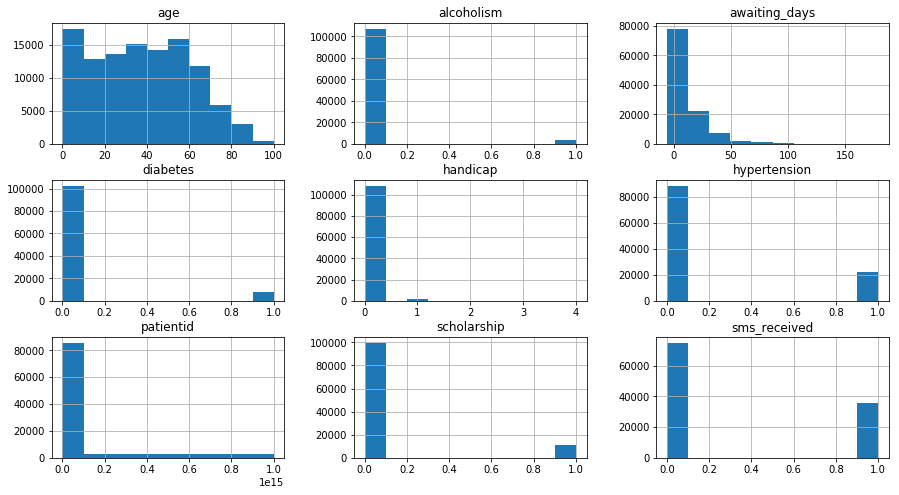

In [17]:
# plot hists
df.hist(figsize=(15,8));

### Explore correlation between other variables and no-show

#####  No-show vs. Show-up rate

Text(0.5,1,'no-show vs. show-up rate')

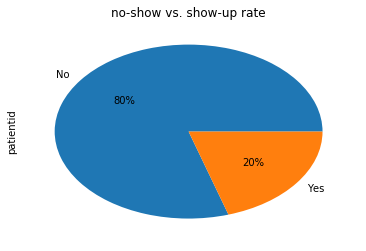

In [26]:
df.groupby('no-show')['patientid'].count().plot(kind='pie',autopct='%.0f%%')
plt.title('no-show vs. show-up rate')

##### Coorelation between 'gender' and 'no-show'

Text(0.5,1,'patients gender vs. no-show')

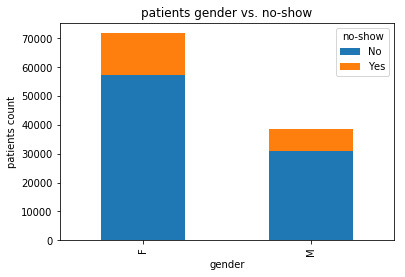

In [36]:
df.groupby(['gender','no-show'])['patientid'].count().unstack().plot(kind='bar',stacked='True')
plt.ylabel('patients count')
plt.title('patients gender vs. no-show')

###### *It shows similar ratio of 'no-show' in male and female patients 

##### Coorelation between 'awaiting days' and 'no-show'

Text(0.5,1,'awaiting days show-up vs. no-show')

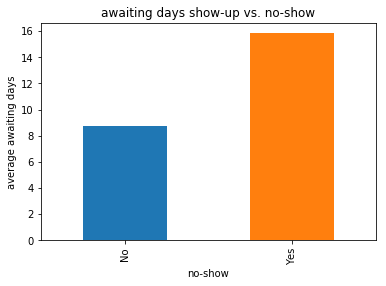

In [29]:
df.groupby('no-show')['awaiting_days'].mean().plot(kind='bar')
plt.ylabel('average awaiting days')
plt.title('awaiting days show-up vs. no-show')

##### *It shows that no-show patients had double awaiting_days that of show-up patients.

##### Coorelation between 'appointment_weekday'&'scheduled_weekday' and 'no-show'

Text(0.5,1,'appointment_weekday patients percentage')

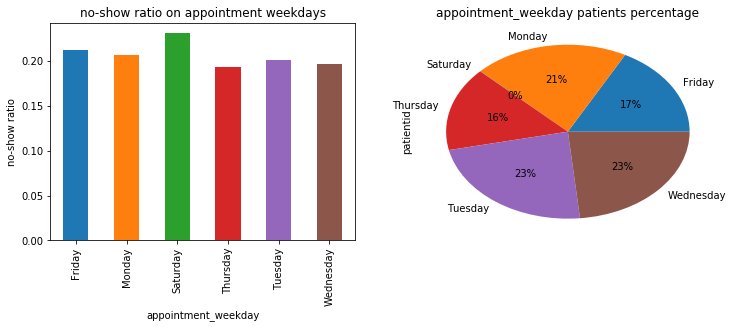

In [39]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_ratio_weekday1=df[df['no-show'] == 'Yes'].groupby('appointment_weekday').size()/df.groupby('appointment_weekday').size()
df_ratio_weekday1.plot(kind='bar',title='no-show ratio on appointment weekdays')
plt.ylabel('no-show ratio')

plt.subplot(122)
df.groupby('appointment_weekday')['patientid'].count().plot(kind='pie',autopct='%.0f%%')
plt.title('appointment_weekday patients percentage')

Text(0.5,1,'scheduled_weekday patients percentage')

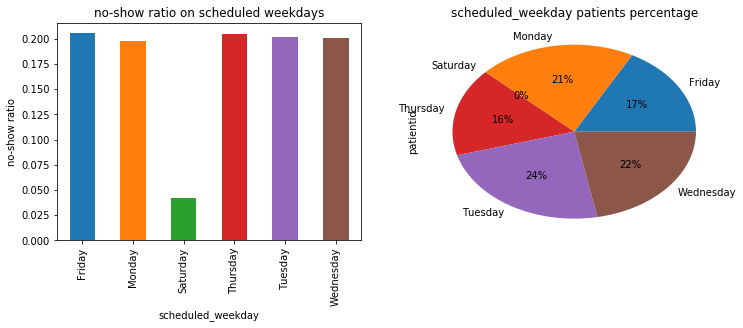

In [40]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_ratio_weekday2=df[df['no-show'] == 'Yes'].groupby('scheduled_weekday').size()/df.groupby('scheduled_weekday').size()
df_ratio_weekday2.plot(kind='bar',title='no-show ratio on scheduled weekdays')
plt.ylabel('no-show ratio')

plt.subplot(122)
df.groupby('scheduled_weekday')['patientid'].count().plot(kind='pie',autopct='%.0f%%')
plt.title('scheduled_weekday patients percentage')

##### *Very few almost no patients made or had appointments on Saturday.It doesn't show too much correlation between appointment & schedueed weekday and no-show.

##### Coorelation between 'age' and 'no-show'

Text(0,0.5,'patients count')

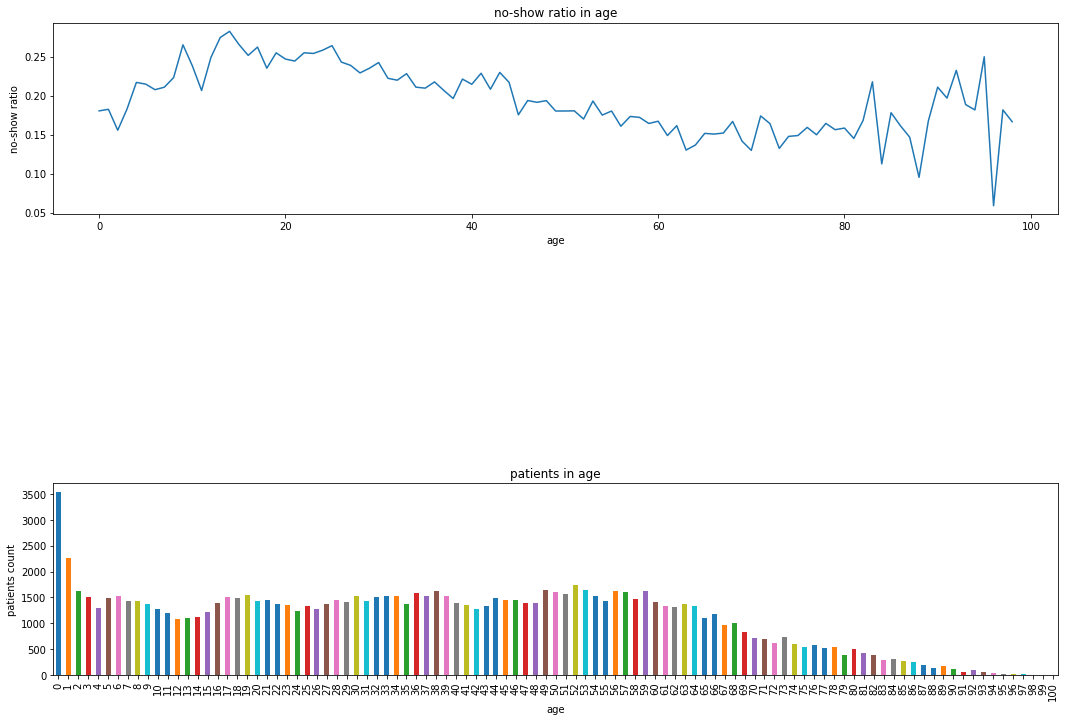

In [48]:
plt.figure(figsize=(18,18))

plt.subplot(311)
df_ratio_age=df[df['no-show'] == 'Yes'].groupby('age').size()/df.groupby('age').size()
df_ratio_age.plot(figsize=(18,12),title='no-show ratio in age')
plt.ylabel('no-show ratio')

plt.subplot(313)
df.groupby('age')['patientid'].count().plot(figsize=(18,12),kind='bar',title='patients in age')
plt.ylabel('patients count')

##### *It shows that patients between 10 to 30 are more likely to no-show.

##### Coorelation between 'sms_received' and 'no-show'

Text(0.5,1,'sms_received patients percentage')

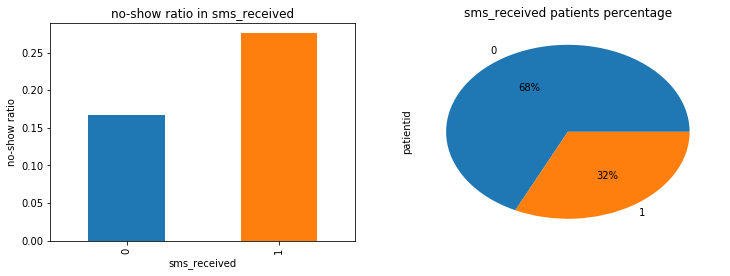

In [35]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_ratio_SMS=df[df['no-show'] == 'Yes'].groupby('sms_received').size()/df.groupby('sms_received').size()
df_ratio_SMS.plot(kind='bar',title='no-show ratio in sms_received')
plt.ylabel('no-show ratio')

plt.subplot(122)
df.groupby('sms_received')['patientid'].count().plot(kind='pie',autopct='%.0f%%')
plt.title('sms_received patients percentage')

##### *This result is definitely beyond my expectation, the data shows patients received sms had higher no-show ratio.

##### Coorelation between 'neighbourhood' and 'no-show'

Text(0,0.5,'patients count')

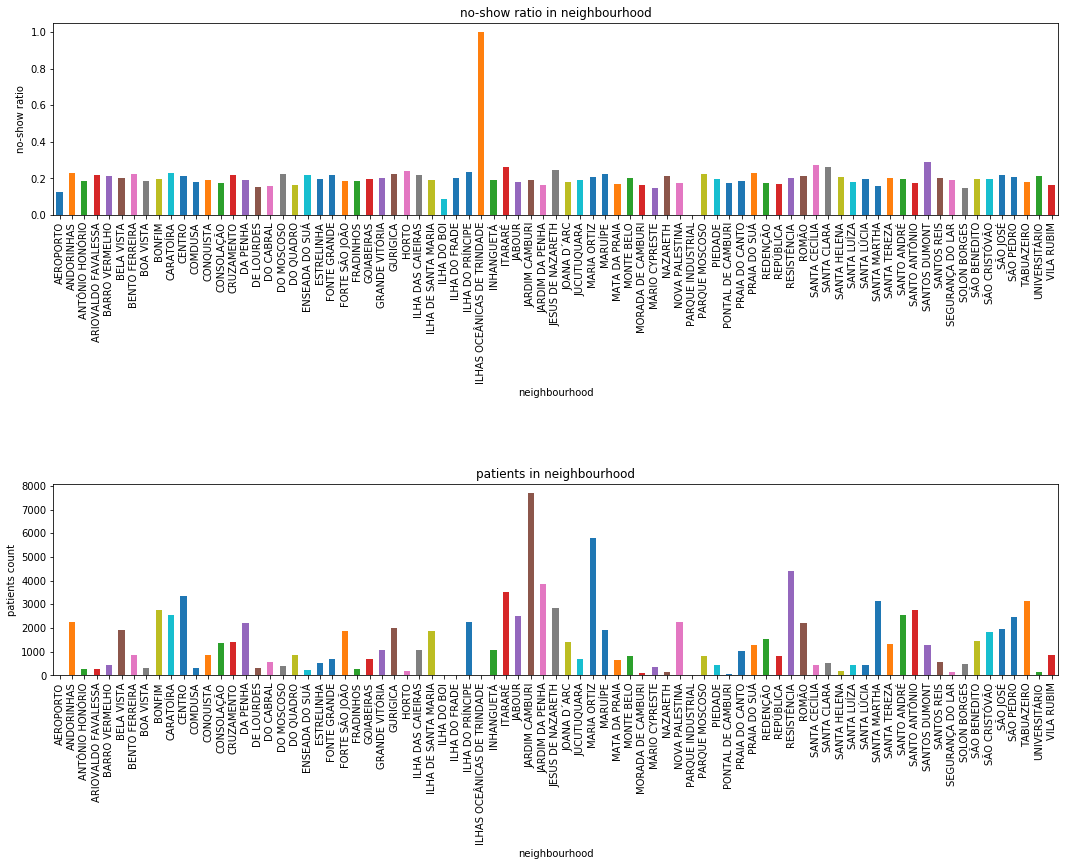

In [49]:
plt.figure(figsize=(18,18))

plt.subplot(311)
df_ratio_Neig=df[df['no-show'] == 'Yes'].groupby('neighbourhood').size()/df.groupby('neighbourhood').size()
df_ratio_Neig.plot(kind='bar',figsize=(18,10),title='no-show ratio in neighbourhood')
plt.ylabel('no-show ratio')

plt.subplot(313)
df.groupby('neighbourhood')['patientid'].count().plot(figsize=(18,12),kind='bar',title='patients in neighbourhood')
plt.ylabel('patients count')

##### *Few patients caused super high or super low level of no-show ratio to hospitals,like 'ILHAS OCEANICAS DE TRINDADE' (with almost 100% no-show) and 'PARQUE INDUSTRIAL'(with almost 100% show-up'.

##### Coorelation between 'scholarship' and 'no-show'

Text(0.5,1,'scholarship patients percentage')

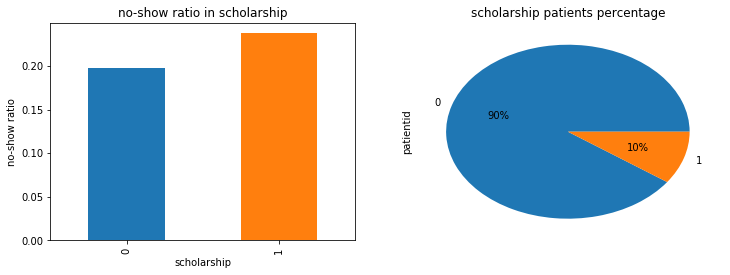

In [52]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_ratio_scholar=df[df['no-show'] == 'Yes'].groupby('scholarship').size()/df.groupby('scholarship').size()
df_ratio_scholar.plot(kind='bar',title='no-show ratio in scholarship')
plt.ylabel('no-show ratio')

plt.subplot(122)
df.groupby('scholarship')['patientid'].count().plot(kind='pie',autopct='%.0f%%')
plt.title('scholarship patients percentage')

##### *no strong correlation was found.

##### Coorelation between illness and 'no-show'

Text(0.5,1,'hypertension patients percentage')

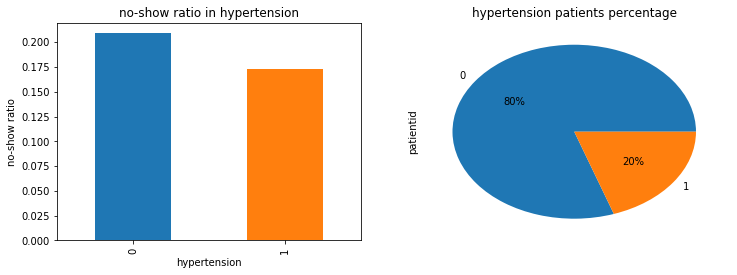

In [54]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_ratio_hypert=df[df['no-show'] == 'Yes'].groupby('hypertension').size()/df.groupby('hypertension').size()
df_ratio_hypert.plot(kind='bar',title='no-show ratio in hypertension')
plt.ylabel('no-show ratio')

plt.subplot(122)
df.groupby('hypertension')['patientid'].count().plot(kind='pie',autopct='%.0f%%')
plt.title('hypertension patients percentage')

Text(0.5,1,'diabetes patients percentage')

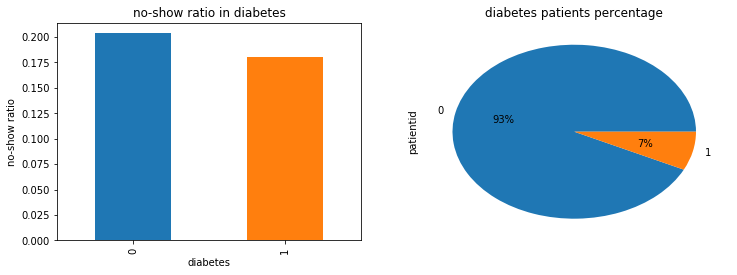

In [55]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_ratio_diab=df[df['no-show'] == 'Yes'].groupby('diabetes').size()/df.groupby('diabetes').size()
df_ratio_diab.plot(kind='bar',title='no-show ratio in diabetes')
plt.ylabel('no-show ratio')

plt.subplot(122)
df.groupby('diabetes')['patientid'].count().plot(kind='pie',autopct='%.0f%%')
plt.title('diabetes patients percentage')

Text(0.5,1,'alcoholism patients percentage')

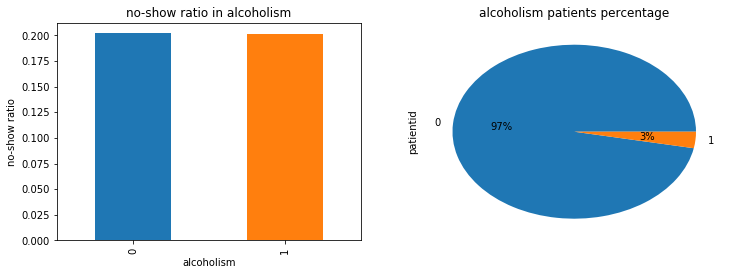

In [56]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_ratio_alcoh=df[df['no-show'] == 'Yes'].groupby('alcoholism').size()/df.groupby('alcoholism').size()
df_ratio_alcoh.plot(kind='bar',title='no-show ratio in alcoholism')
plt.ylabel('no-show ratio')


plt.subplot(122)
df.groupby('alcoholism')['patientid'].count().plot(kind='pie',autopct='%.0f%%')
plt.title('alcoholism patients percentage')

Text(0,0.5,'patients count')

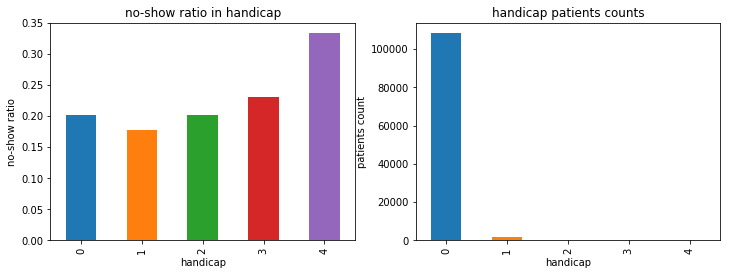

In [59]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_ratio_handicap=df[df['no-show'] == 'Yes'].groupby('handicap').size()/df.groupby('handicap').size()
df_ratio_handicap.plot(kind='bar',title='no-show ratio in handicap')
plt.ylabel('no-show ratio')

plt.subplot(122)
df.groupby('handicap')['patientid'].count().plot(kind='bar',title='handicap patients counts')
plt.ylabel('patients count')

##### *Too few handicap patients to figure out correlation.

<a id='conclusions'></a>
## Conclusion

> There are 20% patients didn't show-up after they scheduled an appoitment with doctors in this dataset.Based on exploratory analysis it shows that patients with following characters:
> 1. longer awaiting-days (with 16 average awaiting days)
> 2. age between 10 to 30
>
are more likely to no-show.
> 
We can't get causality from this correlation analysis.More statistic analyses are needed.



In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])